In [1]:
import os
import json
import math
import random
import itertools
import numpy as np
import networkx as nx
import tqdm as tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from protocols import MPC_protocol, MPG_protocol, SP_protocol
from graph import network, set_p_edge

from joblib import Parallel, delayed
from networkx.algorithms.community import greedy_modularity_communities
from networkx.drawing.layout import *



In [2]:
mkr = ['x','+','d','o','1','2']+['x']*100
dashs = ['-.','--',':','-']+['-']*100
cols = ['gray','g','b','orange','r','k','purple']+['k']*100
linewidth = 2.2
mks = 5.5
fontsize = 14

Find the ER for the MPC, MPG, and SP protocols

In [3]:
def load_data(filepath):
    pos = {}
    user = []

    # Step 1: 读取 JSON 文件
    with open(filepath, "r") as f:
        data = json.load(f)

    # Step 2: 初始化图
    G = nx.Graph()

    # Step 3: 添加节点

    for node in data["nodes"]:
        node_id = node["id"]
        x, y = node["latitude"], node["longitude"]
        G.add_node(node_id, location=node["location"], country=node["country"])  # 添加节点到图
        pos[node_id] = (y, x)  # 保存节点位置，注意 (longitude, latitude)

    # Step 4: 添加边
    for edge in data["links"]:
        source = int(edge["source"])
        target = int(edge["target"])
        G.add_edge(source, target, length=edge["length"])  # 添加边到图

    degree_dict = dict(G.degree())
    degree_items = list(degree_dict.items())
    first_node,first_degree = degree_items[0]
    print(f"First node ID: {first_node}, Degree: {first_degree}")

    user.append(data["nodes"][0]["id"])
    # for item in itertools.islice(reversed(list(data["nodes"])), first_degree):
    #     user.append(item['id'])
    # print(user)
    return G,user,pos

In [4]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def multi_iterative_score_partition_with_drawing(
    G, 
    fixed_node, 
    alpha=1.0, 
    beta=1.0,
    max_rounds=10,
    shuffle_nodes=True,
    pos=None,
    output_path=None
):
    """
    多轮迭代版“打分 + 搬家”分社区并绘制图：
      - 社区数 = degree(fixed_node) + 1
      - 初始:0号社区放 fixed_node,其余每个邻居一个社区
      - 分配时:score = alpha * distance + beta * community_size
      - 多轮:如果搬家能让节点的score降低,就搬家,直到稳定或max_rounds
      - 可选：绘制最终的社区图。

    参数:
        G (nx.Graph): 输入图
        fixed_node (int): 固定节点
        alpha (float): 距离权重
        beta (float): 社区规模权重
        max_rounds (int): 最大迭代轮数
        shuffle_nodes (bool): 每轮是否随机打乱节点遍历顺序
        pos (dict): 每个节点的坐标位置，格式 {node: (x, y)}
        output_path (str, 可选): 保存图片的路径。如果为 None,则只显示图像不保存。

    返回:
        communities (List[Set]): 列表长度 = degree(fixed_node) + 1,
                                 第0个 = {fixed_node},
                                 第 i+1 个 = 第 i 个邻居的社区。
        key_nodes (List[int]): 包含 fixed_node 以及各社区最远节点的列表。
    """

    # 1) 根据固定节点度数 => 准备社区容器
    neighbors = list(G.neighbors(fixed_node))
    print(f"the neighbors are {neighbors}")
    num_communities = len(neighbors)
    communities = [set() for _ in range(num_communities + 1)]
    visited = set()

    # 第0个社区放 fixed_node
    communities[0].add(fixed_node)
    visited.add(fixed_node)

    # 其余邻居各一个社区
    for i, nb in enumerate(neighbors, start=1):
        communities[i].add(nb)
        visited.add(nb)

    # 2) 初始化: 单轮分配 - 把剩余节点分配到“初次”score最小的社区
    for node in G.nodes():
        if node not in visited:
            best_score = float('inf')
            best_index = None
            for i, nb in enumerate(neighbors, start=1):
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size
                if score < best_score:
                    best_score = score
                    best_index = i
            communities[best_index].add(node)
            visited.add(node)

    # 3) 多轮迭代搬家
    round_num = 0
    while round_num < max_rounds:
        round_num += 1
        moved_count = 0

        # 获取所有节点（除 fixed_node 外），看要不要搬家
        all_nodes = [n for n in G.nodes() if n != fixed_node]

        # 是否随机打乱节点遍历顺序？
        if shuffle_nodes:
            random.shuffle(all_nodes)

        for node in all_nodes:
            # 当前所在社区 idx
            current_idx = None
            for i, comm in enumerate(communities):
                if node in comm:
                    current_idx = i
                    break

            # 算一下“当前score”
            if current_idx == 0:
                continue  # 固定节点不搬家

            nb_current = neighbors[current_idx - 1] if current_idx > 0 else fixed_node
            dist_current = nx.shortest_path_length(G, source=node, target=nb_current)
            size_current = len(communities[current_idx])
            current_score = alpha * dist_current + beta * size_current

            # 尝试搬去别的社区，看score是否更低
            best_score = current_score
            best_index = current_idx

            for i, nb in enumerate(neighbors, start=1):
                if i == current_idx:
                    continue  # 跳过自己
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size

                if score < best_score:
                    best_score = score
                    best_index = i

            # 如果找到更好的社区 => 搬家
            if best_index != current_idx:
                communities[current_idx].remove(node)
                communities[best_index].add(node)
                moved_count += 1

        #print(f"Round {round_num}: moved {moved_count} nodes")

        # 如果没有节点搬家 => 收敛 => 停止
        if moved_count == 0:
            break

    # 打印最终结果
    # print("\nFinal communities after iterative refinement:")
    # for i, comm in enumerate(communities):
    #     print(f"Community {i} (size={len(comm)}): {sorted(comm)}")

    # 找出每个社区中距离 fixed_node 最远的节点
    farthest_nodes = []
    for i, community in enumerate(communities):
        if i == 0:  # 跳过第0个社区，它只包含 fixed_node 本身
            continue
        if not community:  # 跳过空社区
            continue    
        farthest_node = max(community, key=lambda x: nx.shortest_path_length(G, fixed_node, x))
        farthest_nodes.append(farthest_node)

    #print(f"Farthest nodes in each community: {farthest_nodes}")

    # 将 fixed_node 与各社区最远节点合并成一个列表
    key_nodes = [fixed_node] + farthest_nodes
    #print(f"Key nodes (fixed + farthest): {key_nodes}")

    # 绘制社区图
    if pos is None:
        pos = nx.spring_layout(G, seed=42)  # 默认布局

    # 颜色列表，用于区分社区
    colors = ["red", "blue", "green", "orange", "purple", "cyan", "yellow", "pink"]
    
    plt.figure(figsize=(8, 6))
    
    # 绘制每个社区
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(
            G, pos, nodelist=community,
            node_color=colors[i % len(colors)], 
            label=f"Community {i}",
            alpha=0.8,
            node_size=100
        )

    # 特别标注固定节点（用圆形）
    nx.draw_networkx_nodes(
        G, pos, nodelist=[fixed_node],
        node_color="red", node_shape="o",
        node_size=100, alpha=0.9, label="Fixed Node"
    )
    # 特别标注最远节点（用三角形）
    nx.draw_networkx_nodes(
        G, pos, nodelist=farthest_nodes,
        node_color="gold", node_shape="^",
        node_size=100, alpha=0.9, label="Farthest Nodes"
    )

    # 绘制边
    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)

    # 绘制节点标签
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    # 添加图例
    plt.legend(
        fontsize=6,  # 图例字体大小
        borderaxespad=0.5,  # 图例与轴边界的距离
        labelspacing=0.2,   # 图例条目之间的间距
        loc="upper left",  # 图例位置
        bbox_to_anchor=(1.05, 1),  # 将图例放到图外
    )
    plt.title("Graph with Colored Communities and Key Nodes")
    
    # 调整图形边距
    plt.tight_layout(pad=2.0)

    # 保存或显示图像
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Graph saved to {output_path}")
    else:
        plt.show()

    # 关闭图形以释放内存
    plt.close()

    # 返回社区列表，以及 [fixed_node + 所有最远节点]
    return communities, key_nodes


In [5]:

def plot_er_vs_p(p_range, ER, funcs, cols, output_path, fontsize=12, figsize=(10, 6), dpi=600):
    """
    绘制 ER 与链接生成概率 p 的关系图，并保存为文件。

    参数:
        p_range (array-like): p 的取值范围。
        ER (list of lists): 每个函数对应的 ER 数据。
        funcs (list): 包含函数的列表，用于生成图例名称。
        cols (list): 每个函数对应的颜色列表。
        output_path (str): 保存图片的路径。
        fontsize (int, 可选): 坐标轴和标签字体大小，默认 12。
        figsize (tuple, 可选): 图形大小，默认 (10, 6)。
        dpi (int, 可选): 图像分辨率，默认 600。
    """
    nom_list = [str(f).split(' ')[1] for f in funcs]
    plt.figure(figsize =(10,6),dpi=600 )
    plt.grid(linewidth=0.5)
    for i in range(len(funcs)):
        y = plt.plot(p_range, ER[i],
                    color = cols[i],
                    marker = "x",
                    linestyle='None',
                    markersize = 3,
                    #  alpha = 0.5,
                    #  linewidth=linewidth,
                    label = nom_list[i])
    plt.yscale('log')
    plt.legend(fontsize=10)
    plt.tick_params(labelsize=fontsize)

    plt.xlabel('Link generation probability p',fontsize=fontsize)
    plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)

    ax = plt.gca()
    ax.set_xlim([0.2, 1])
    ax.set_ylim([0.0001, 1])

    # 保存图片
    plt.savefig(output_path, dpi=dpi)
    print(f"Plot saved to {output_path}")

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Aaron\AppData\Local\Temp\ipykernel_18752\2629642242.py:32: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)


In [6]:
def process_single_p(G_base, users, p, funcs, timesteps, reps):
    """处理单个p值的计算任务(兼容joblib)"""
    G = G_base.copy()  # 深拷贝图
    set_p_edge(G, p_op=p)
    ers = []
    for func in funcs:
        er, _, _ = func(G, users, timesteps=timesteps, reps=reps)
        ers.append(er)
    return ers  # 返回当前p值的所有协议ER值

First node ID: 39, Degree: 6
the neighbors are [25, 27, 38, 50, 100, 56]
Graph saved to f:\Third-year\Third-year project\quantum_repeaters_testing\communities\class_0\TOP_104_USA100.png


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   42.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:  1.2min remaining:   53.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:  1.3min remaining:   32.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.5min remaining:   19.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.5min remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


[[1.00000000e+00 9.95024876e-01 9.90099010e-01 9.95024876e-01
  9.80392157e-01 9.75609756e-01 9.09090909e-01 8.96860987e-01
  8.51063830e-01 8.51063830e-01 8.03212851e-01 6.73400673e-01
  6.07902736e-01 5.39083558e-01 5.16795866e-01 4.40528634e-01
  3.69685767e-01 3.16957211e-01 2.38948626e-01 2.07468880e-01
  1.71379606e-01 1.15008626e-01 8.14332248e-02 4.65933037e-02
  3.48549186e-02 2.56094221e-02 1.23425264e-02 6.63716814e-03
  3.33640129e-03 2.14462469e-03 1.05864916e-03 4.07934323e-04
  2.01989598e-04 5.00776203e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 8.51063830e-01 7.66283525e-01 6.47249191e-01
  5.43478261e-01 4.04858300e-01 3.47826087e-01 3.05810398e-01
  2.45398773e-01 1.94741967e-01 1.37646249e-01 9.56480153e-02
  7.06927176e-02 4.71031559e-02 3.619

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.8s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    9.5s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   12.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   14.4s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   17.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   18.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.8s finished


[[1.00000000e+00 9.95024876e-01 9.85221675e-01 9.70873786e-01
  9.52380952e-01 8.96860987e-01 8.58369099e-01 8.65800866e-01
  8.16326531e-01 7.69230769e-01 7.04225352e-01 6.38977636e-01
  6.07902736e-01 4.85436893e-01 4.80769231e-01 4.31965443e-01
  4.29184549e-01 3.46620451e-01 3.01659125e-01 2.63852243e-01
  2.01005025e-01 1.83486239e-01 1.50150150e-01 1.29701686e-01
  9.37646507e-02 7.51314801e-02 5.86338317e-02 4.85247501e-02
  3.48482127e-02 2.81521414e-02 1.97825081e-02 1.67877981e-02
  1.07836089e-02 7.90198637e-03 5.92034446e-03 3.67861731e-03
  1.98052484e-03 1.77089098e-03 1.17027501e-03 7.86410821e-04
  3.04893541e-04 2.02122284e-04 5.01605136e-05 5.00625782e-05
  5.02260171e-05 5.01479364e-05 0.00000000e+00 0.00000000e+00
  5.00225101e-05 0.00000000e+00]
 [1.00000000e+00 9.21658986e-01 8.26446281e-01 7.60456274e-01
  7.04225352e-01 5.55555556e-01 4.78468900e-01 4.44444444e-01
  3.79506641e-01 3.16957211e-01 2.64550265e-01 2.18818381e-01
  1.70068027e-01 1.35777325e-01 1.197

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   13.3s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   28.8s remaining:   33.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   29.9s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   30.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   37.5s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   39.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.5s finished


[[1.00000000e+00 1.00000000e+00 9.75609756e-01 9.52380952e-01
  9.38967136e-01 9.52380952e-01 8.81057269e-01 8.09716599e-01
  7.29927007e-01 6.47249191e-01 6.07902736e-01 5.39083558e-01
  4.95049505e-01 4.37636761e-01 3.75234522e-01 2.93255132e-01
  2.30414747e-01 1.75438596e-01 1.41143260e-01 9.44287063e-02
  5.88060588e-02 4.81490443e-02 2.94844088e-02 2.20453154e-02
  1.22173122e-02 9.48737567e-03 6.55626901e-03 4.41284629e-03
  1.79338079e-03 1.52140839e-03 6.72355831e-04 5.68328597e-04
  1.51316453e-04 2.01318637e-04 0.00000000e+00 5.01529665e-05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.66183575e-01 9.38967136e-01 8.69565217e-01
  8.58369099e-01 7.69230769e-01 7.14285714e-01 6.13496933e-01
  5.73065903e-01 4.78468900e-01 3.83877159e-01 3.80228137e-01
  2.95857988e-01 2.40673887e-01 1.657

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    0.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    1.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    3.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    4.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    5.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    6.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.5s finished


[[1.00000000e+00 9.95024876e-01 9.95024876e-01 9.75609756e-01
  9.56937799e-01 9.56937799e-01 9.47867299e-01 9.00900901e-01
  9.09090909e-01 8.36820084e-01 7.90513834e-01 7.46268657e-01
  7.09219858e-01 6.45161290e-01 6.28930818e-01 6.06060606e-01
  5.69800570e-01 5.39083558e-01 4.51467269e-01 4.32900433e-01
  4.06504065e-01 3.91389432e-01 2.91120815e-01 3.02571861e-01
  2.43013366e-01 1.92307692e-01 1.69923534e-01 1.70068027e-01
  1.36332652e-01 1.19402985e-01 1.00250627e-01 9.21658986e-02
  8.23045267e-02 5.34045394e-02 4.74137931e-02 3.90983443e-02
  2.87015945e-02 2.54016202e-02 1.71225726e-02 1.54226961e-02
  1.20346320e-02 9.15969733e-03 6.54709132e-03 5.26863536e-03
  3.05018416e-03 1.65271632e-03 1.92075513e-03 8.90985325e-04
  4.60499386e-04 6.17283951e-04]
 [1.00000000e+00 8.88888889e-01 8.47457627e-01 7.63358779e-01
  6.99300699e-01 6.96864111e-01 6.02409639e-01 5.12820513e-01
  4.64037123e-01 4.12371134e-01 3.74531835e-01 3.46020761e-01
  2.94985251e-01 2.37529691e-01 2.283

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   23.0s remaining:   44.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   39.4s remaining:   46.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   42.2s remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   44.1s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   56.3s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   57.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.5s finished


[[1.00000000e+00 1.00000000e+00 9.85221675e-01 9.80392157e-01
  9.47867299e-01 9.13242009e-01 8.77192982e-01 7.96812749e-01
  7.38007380e-01 6.89655172e-01 5.81395349e-01 5.27704485e-01
  4.62962963e-01 3.43642612e-01 3.42465753e-01 2.30680507e-01
  1.76366843e-01 1.59108990e-01 1.21580547e-01 7.85237534e-02
  6.07348922e-02 3.64719017e-02 2.23682548e-02 1.31750022e-02
  1.04800000e-02 5.39837398e-03 4.14103891e-03 2.41817568e-03
  1.11976112e-03 4.08914332e-04 2.51736985e-04 1.50466446e-04
  5.00275151e-05 5.02184503e-05 5.01202887e-05 5.00550606e-05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.61538462e-01 8.09716599e-01 6.99300699e-01
  5.66572238e-01 4.90196078e-01 3.71747212e-01 2.77777778e-01
  2.18340611e-01 1.74216028e-01 1.27226463e-01 8.43170320e-02
  5.82750583e-02 4.67465351e-02 2.885

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


KeyboardInterrupt: 

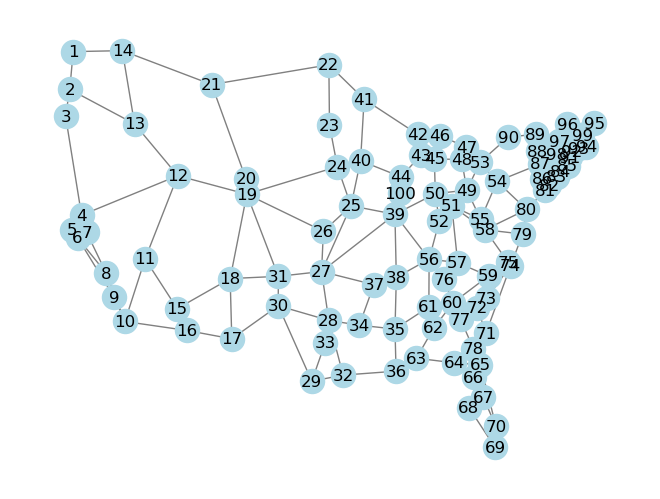

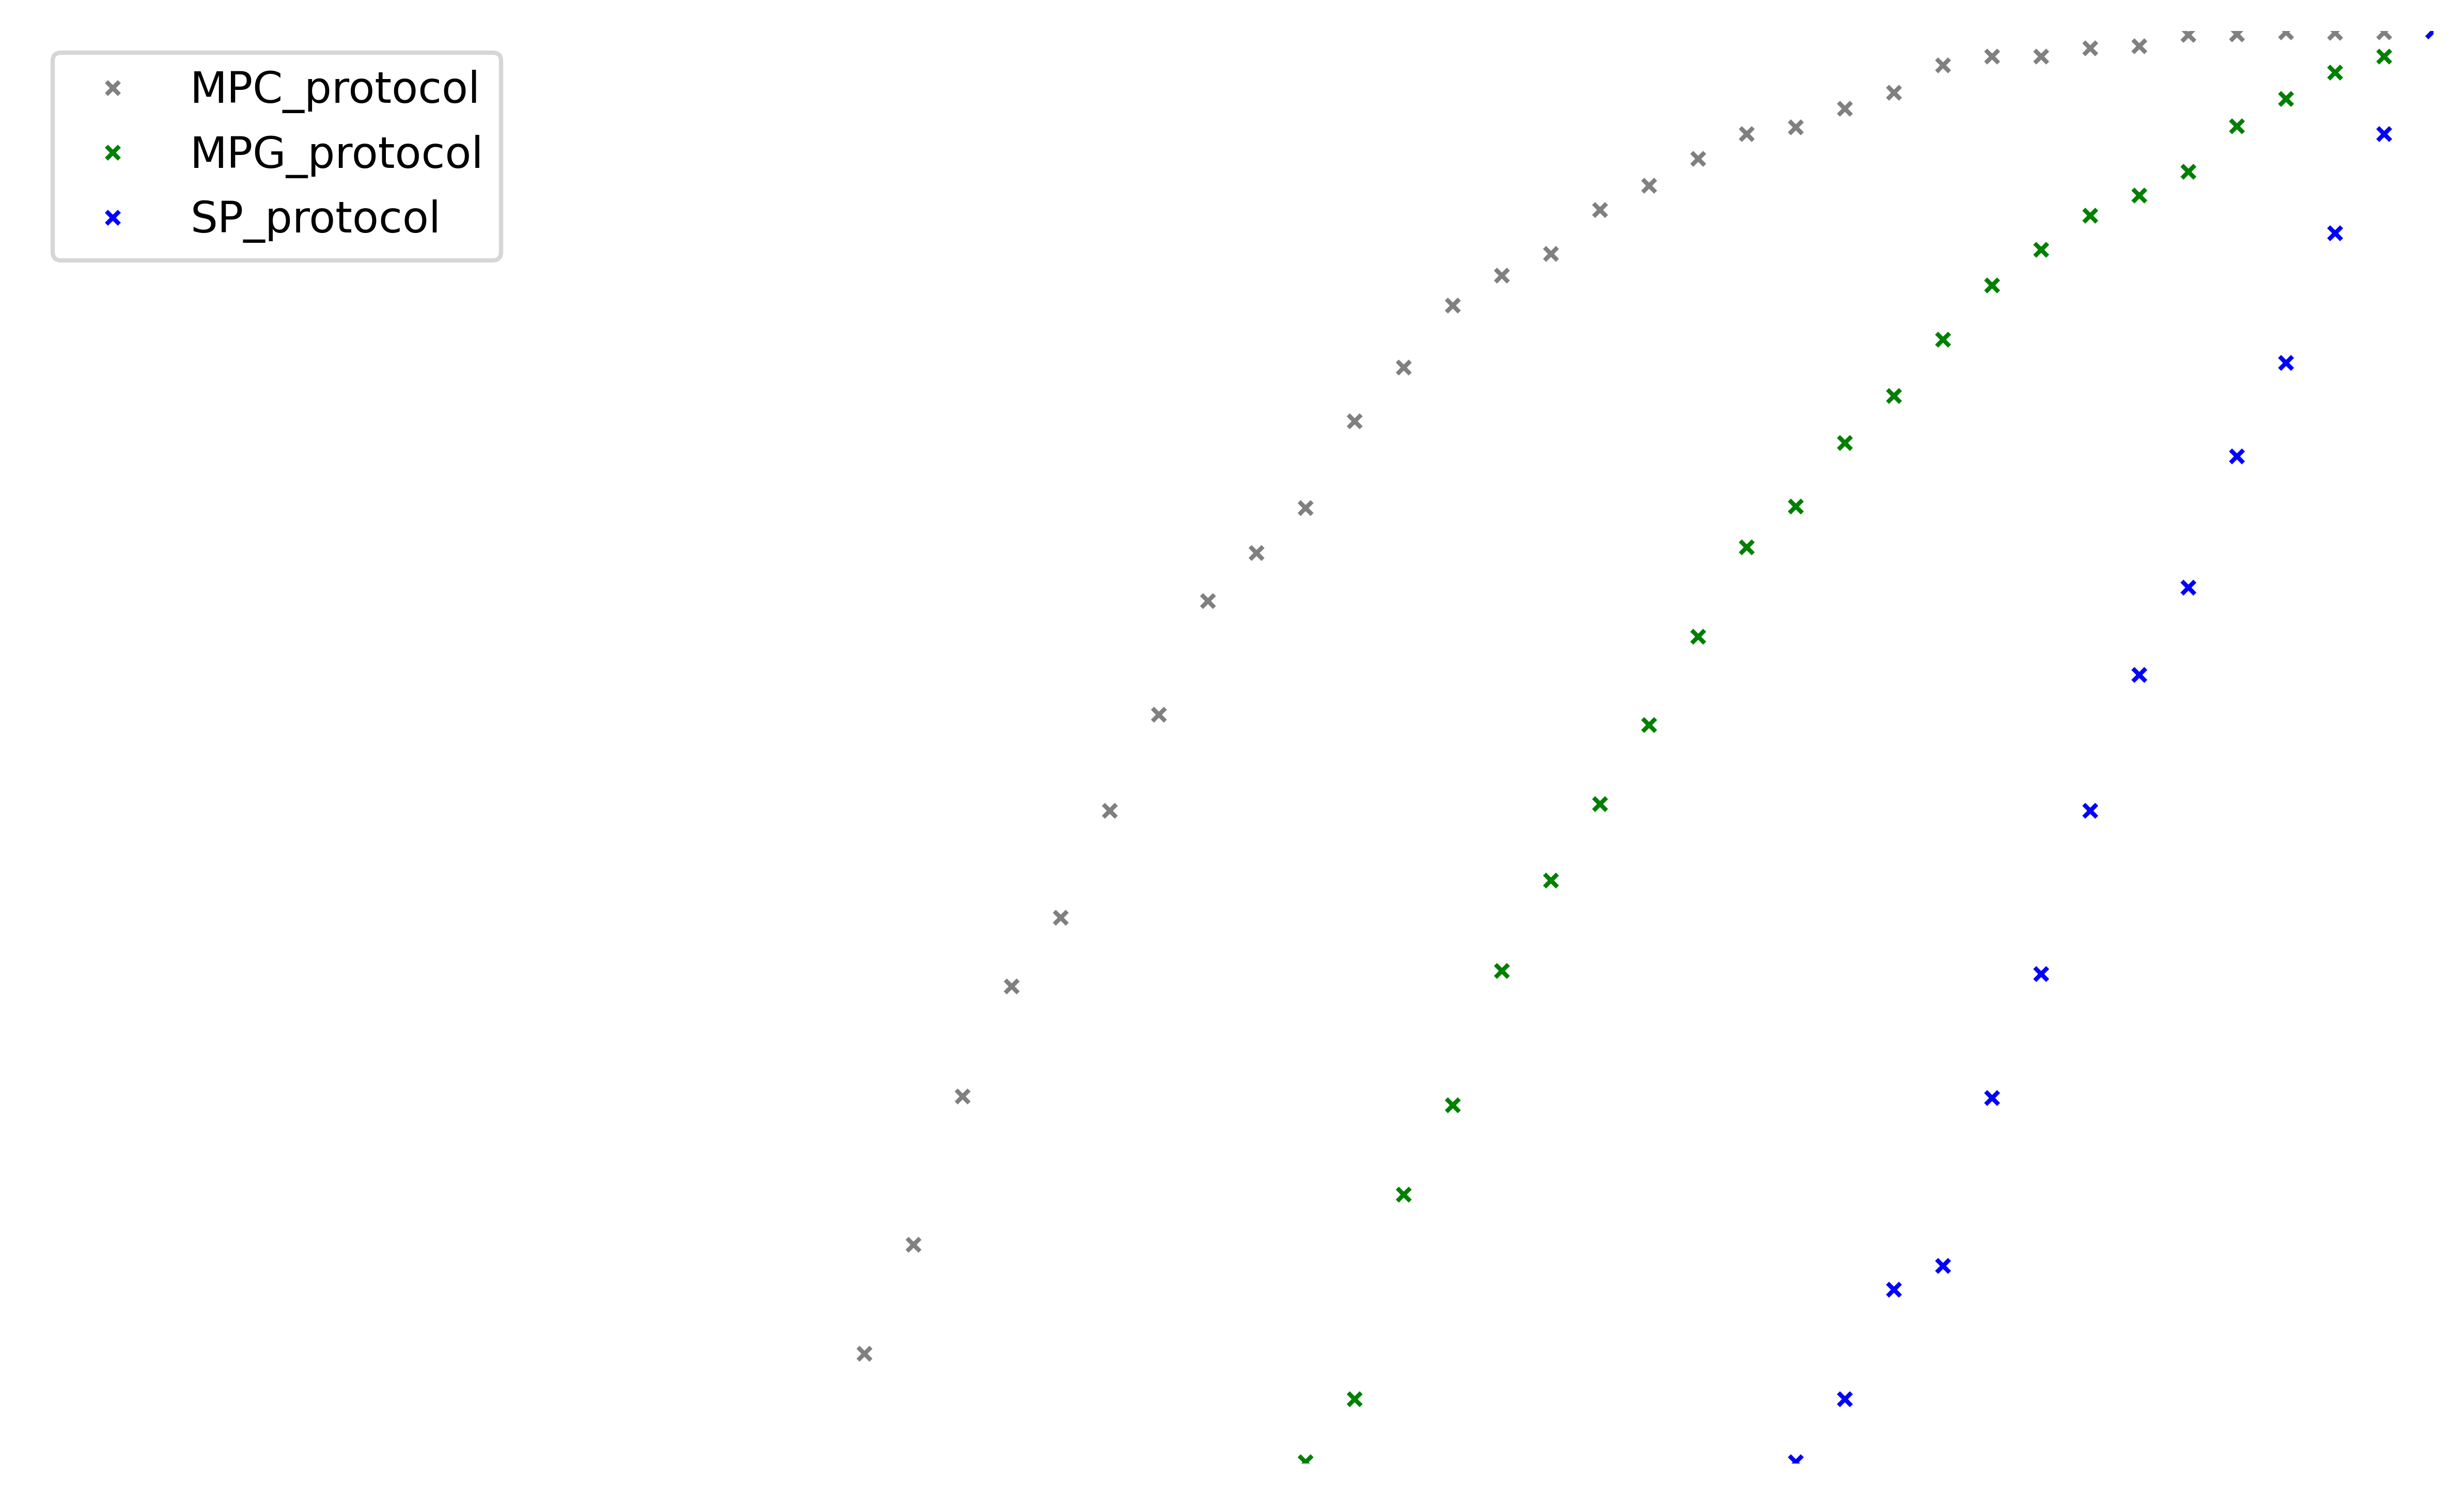

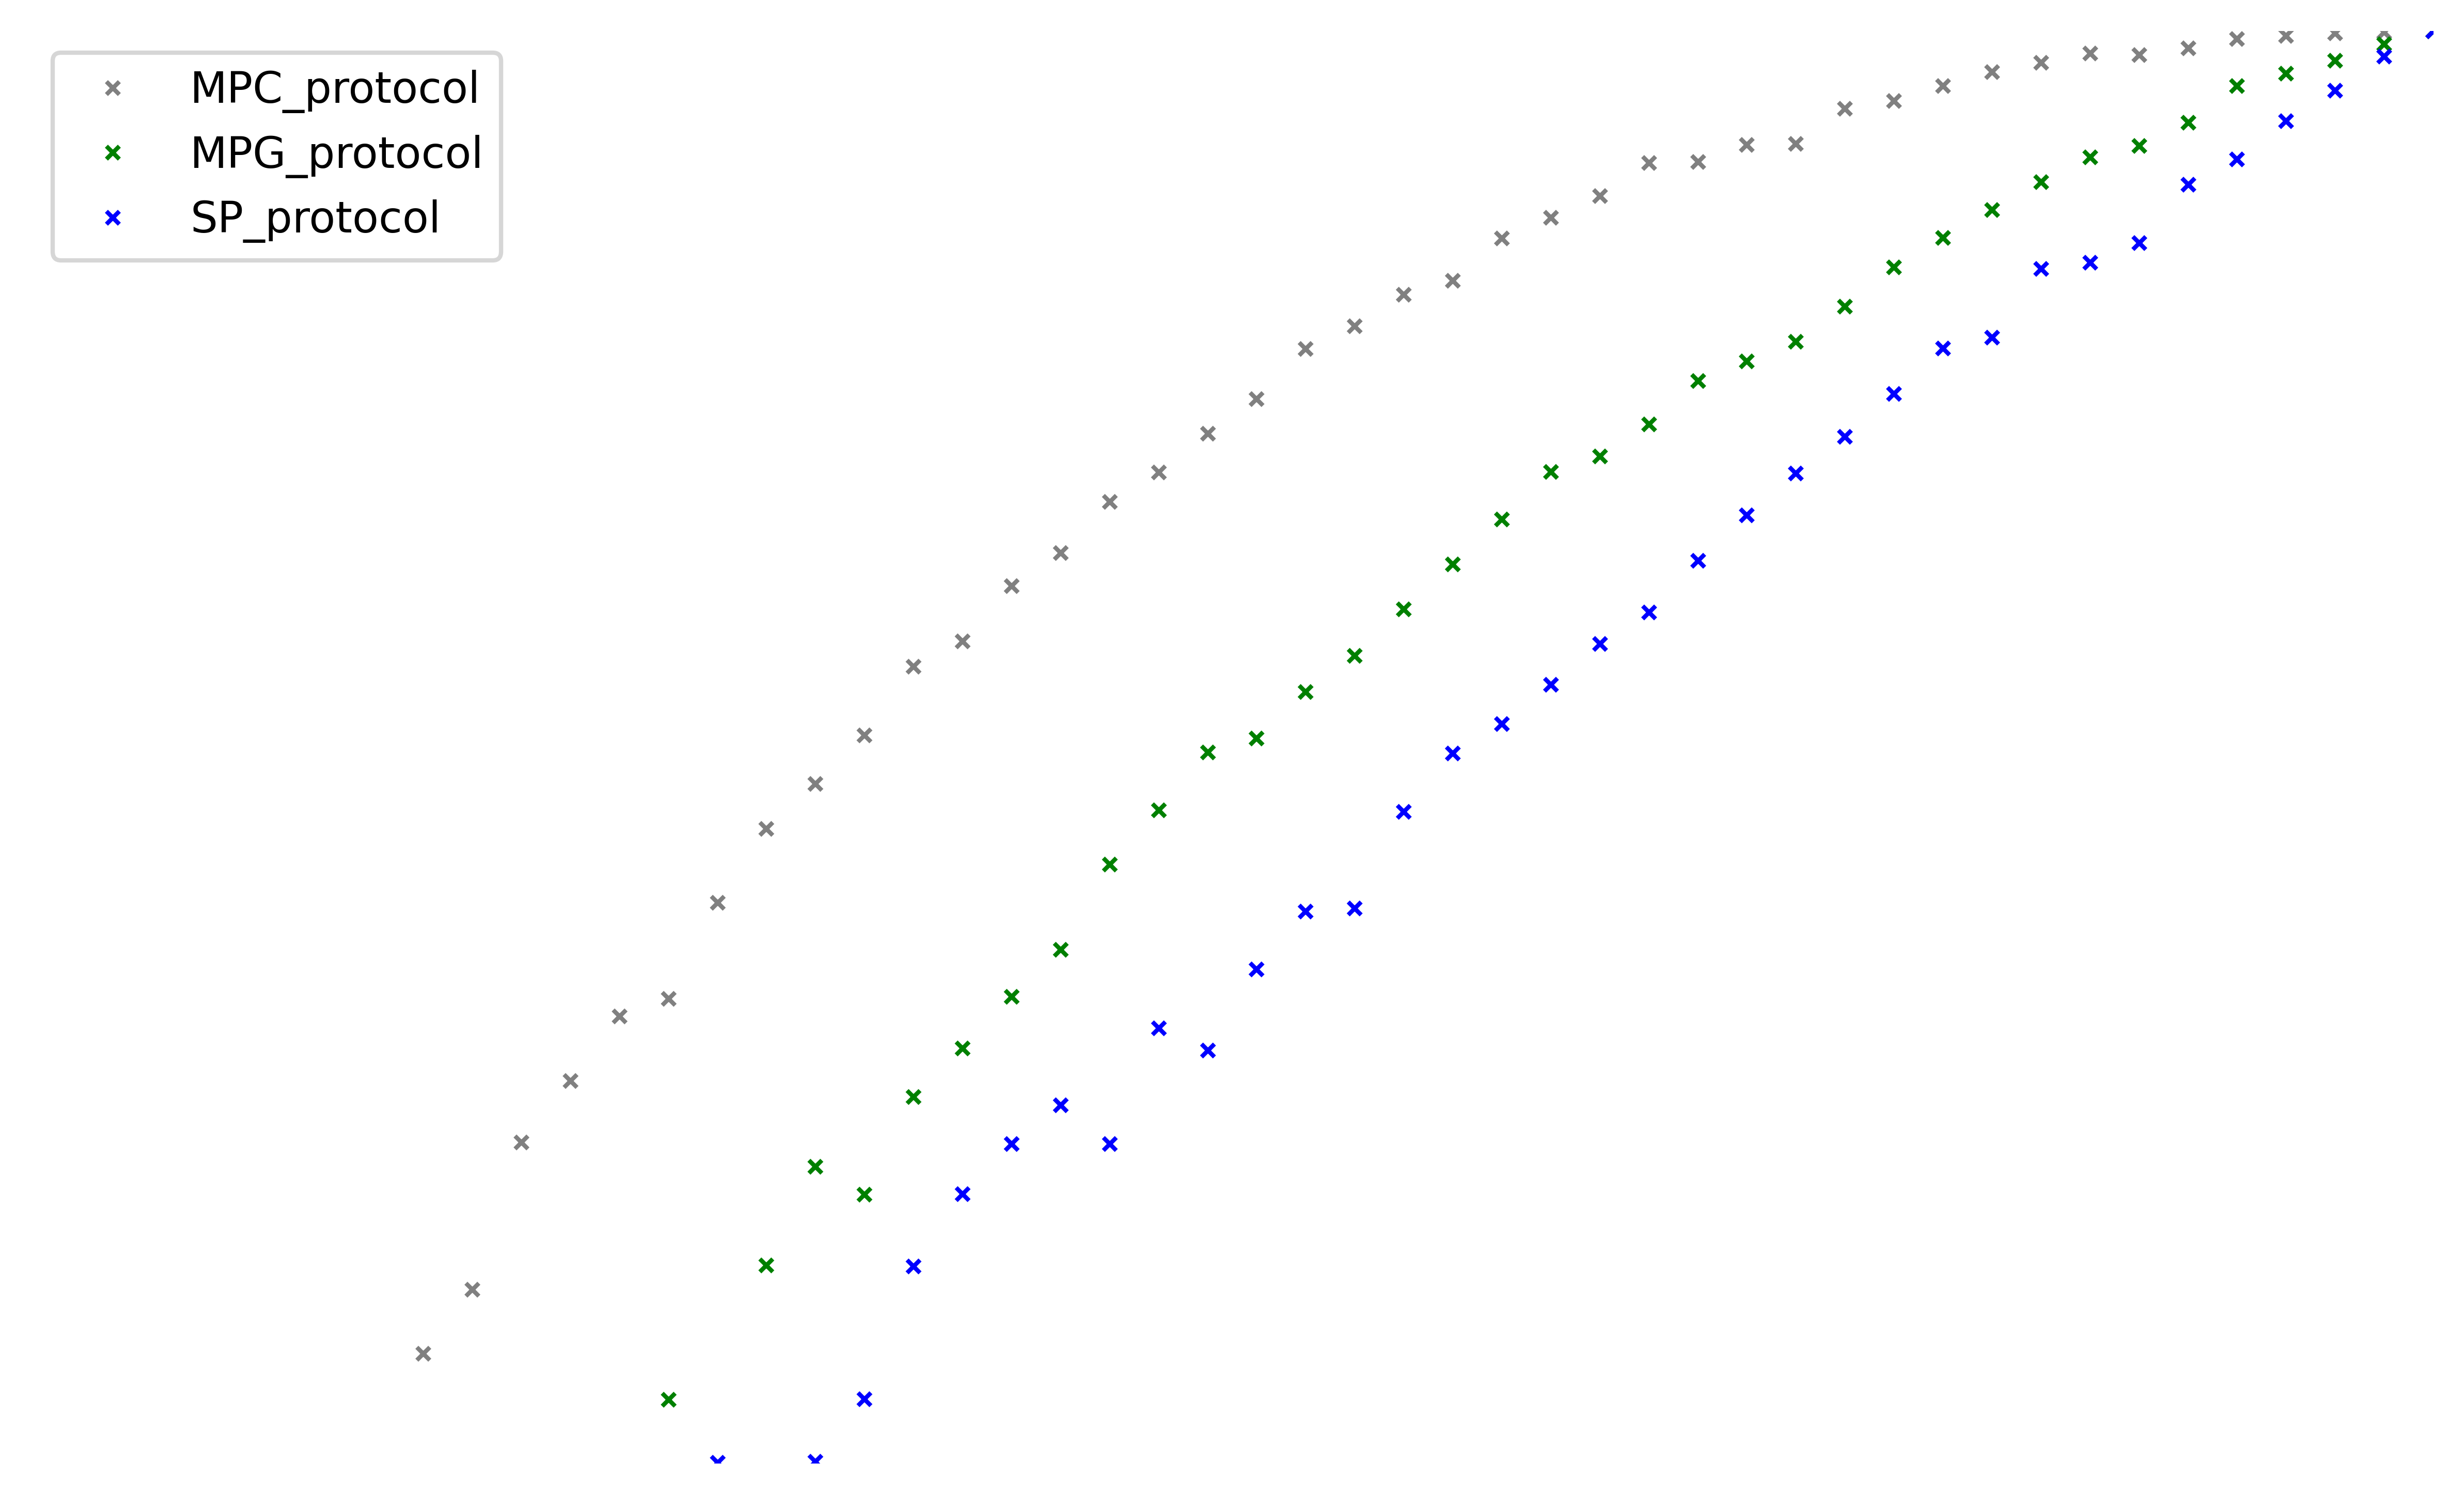

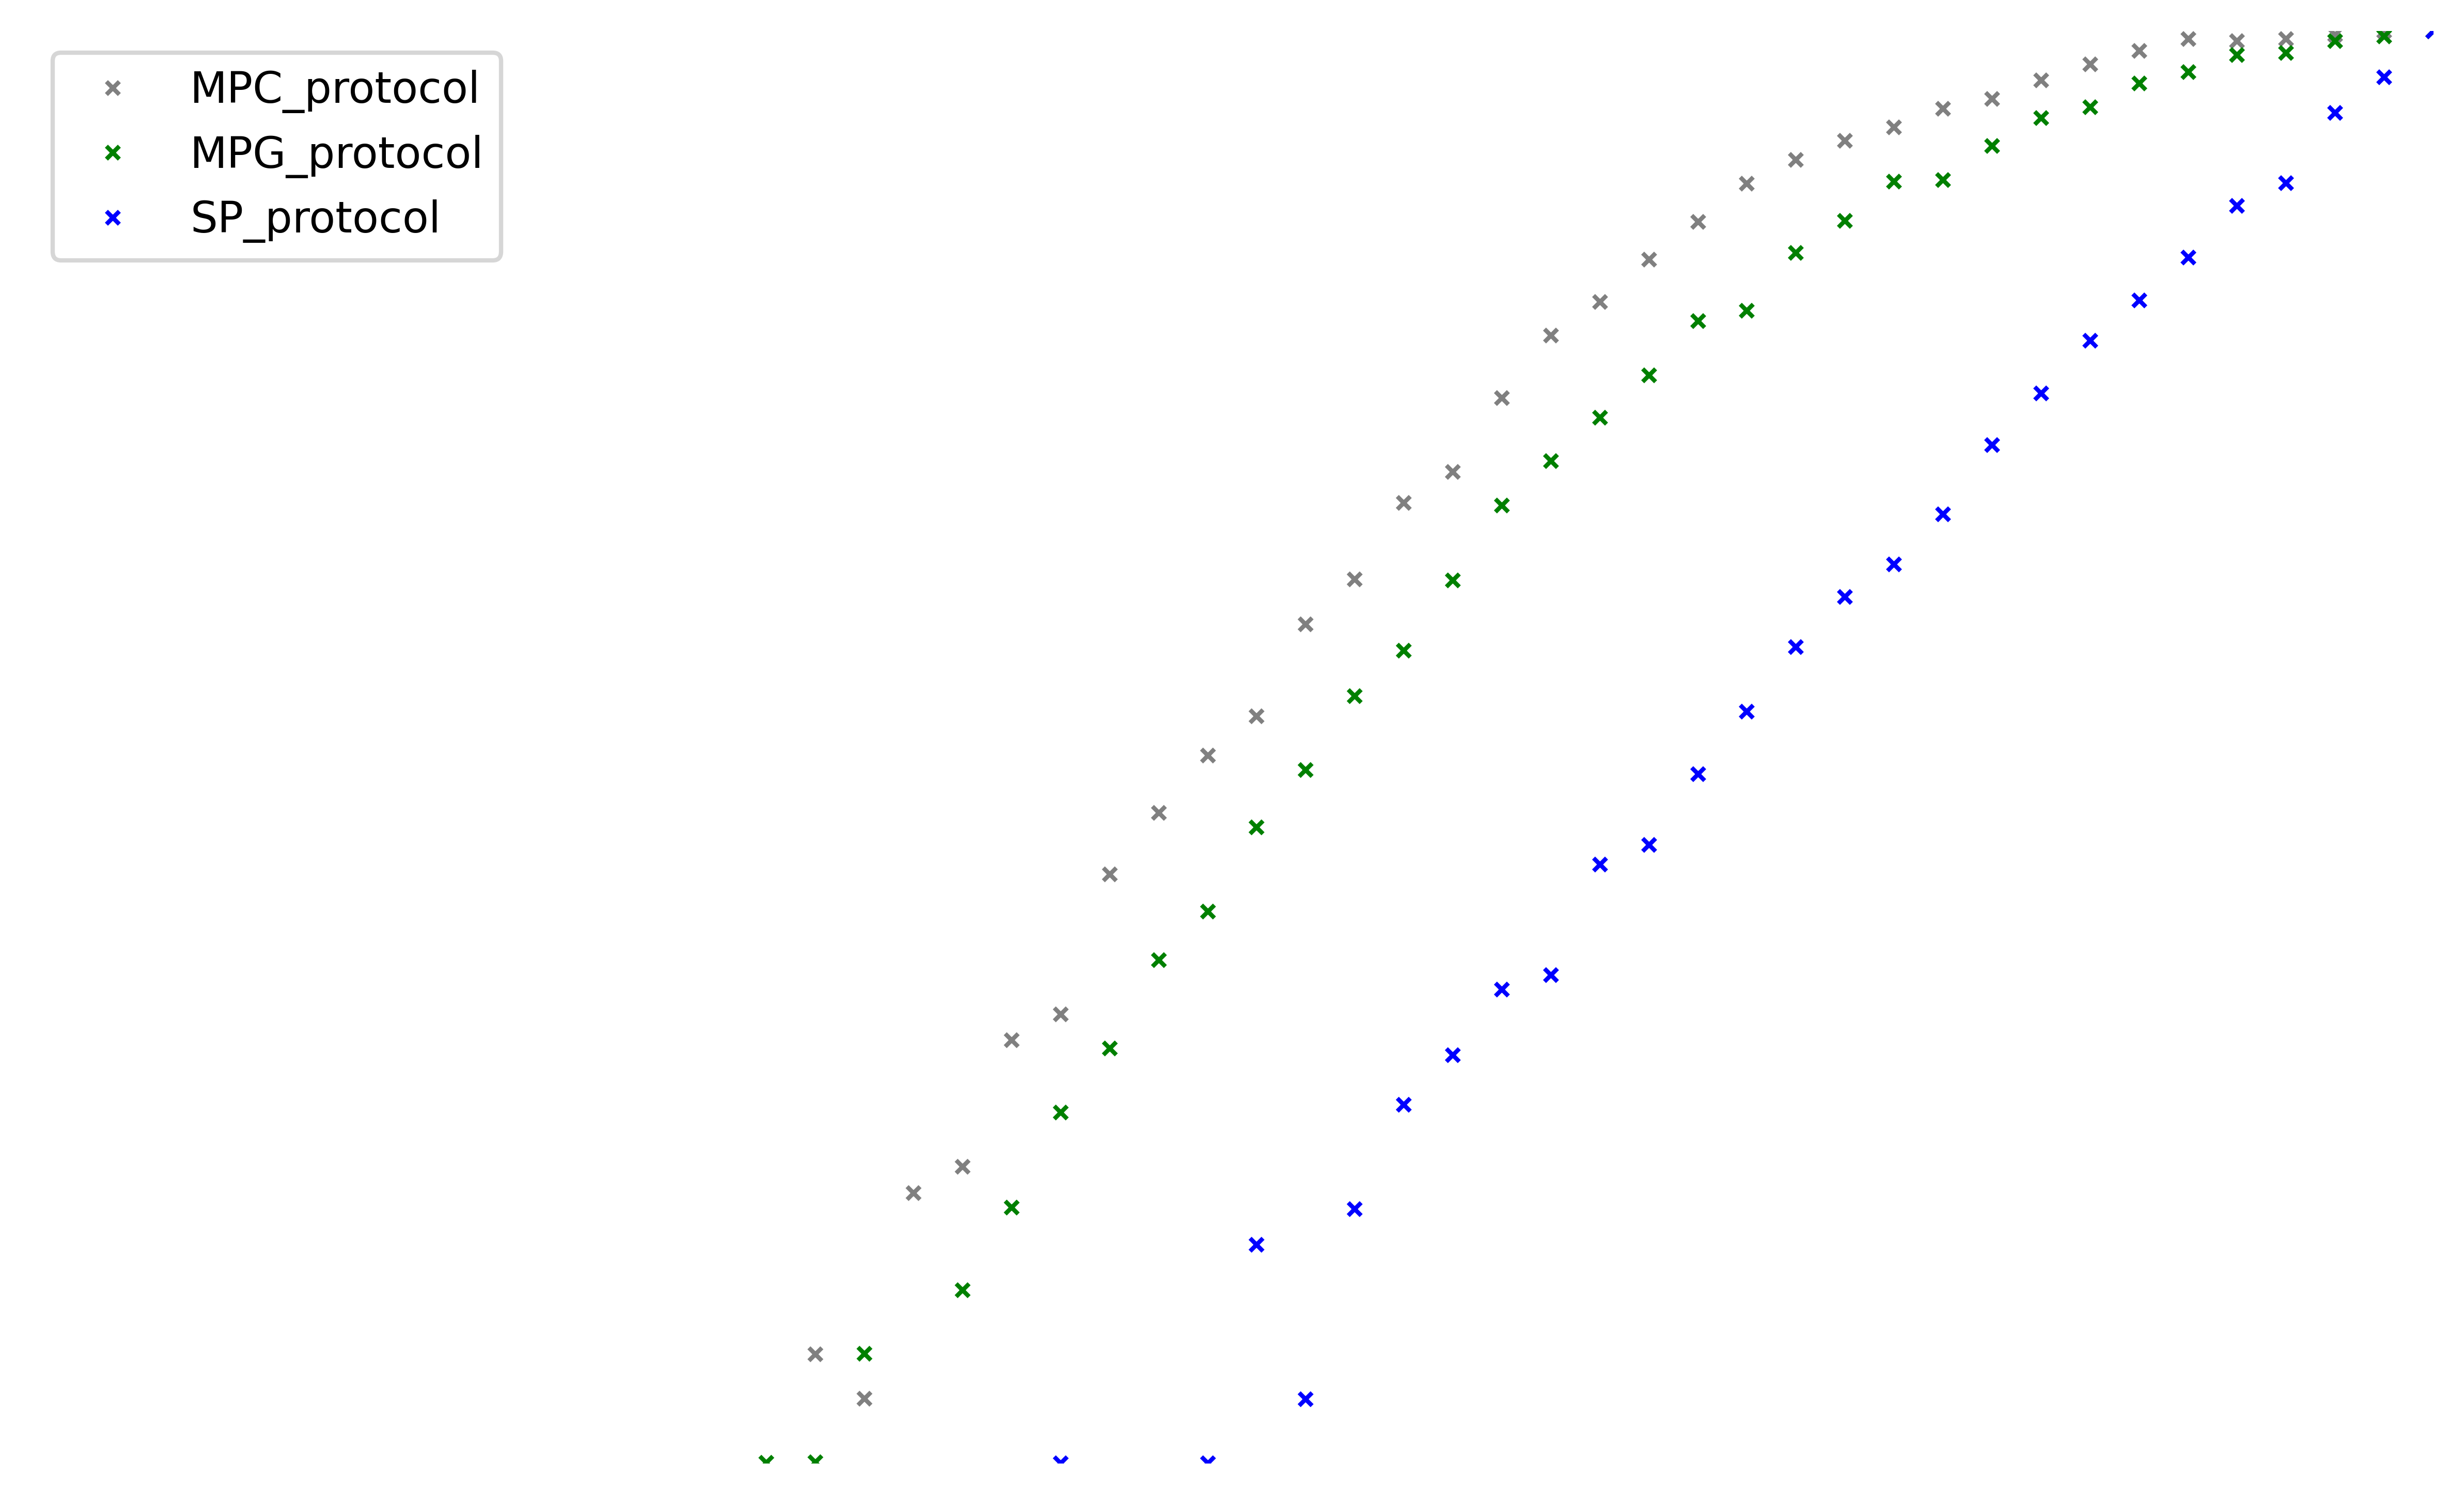

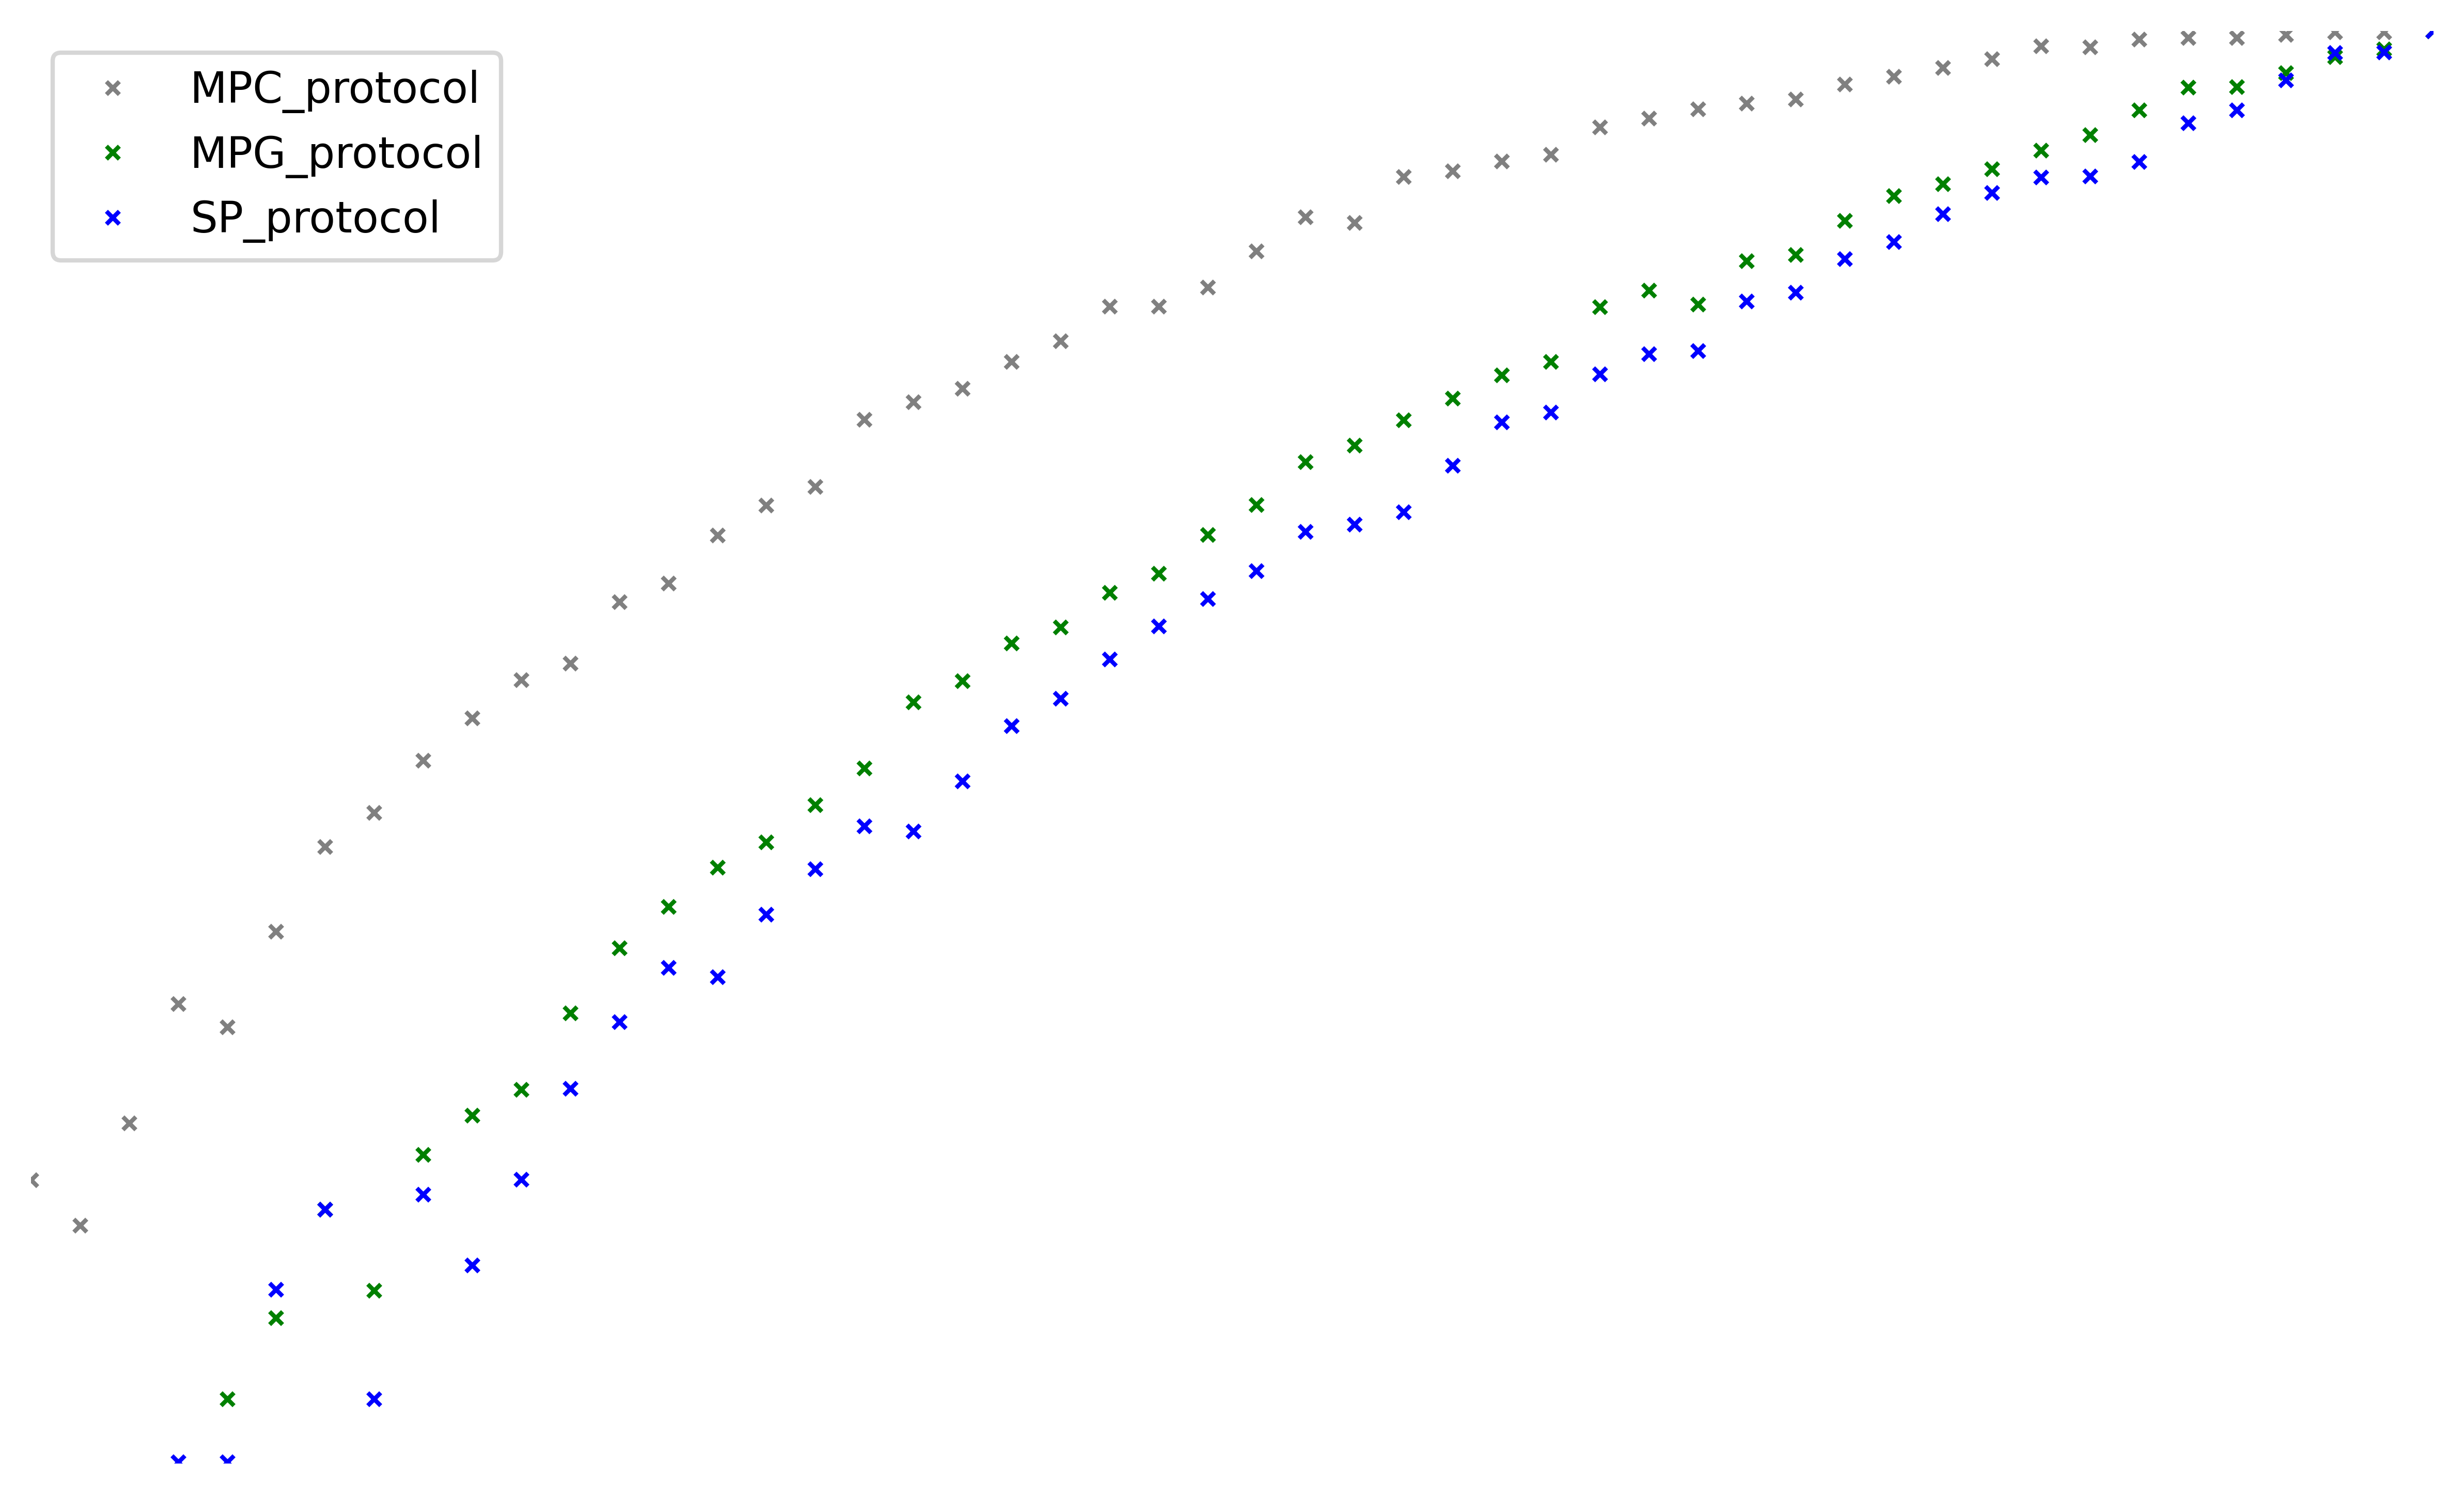

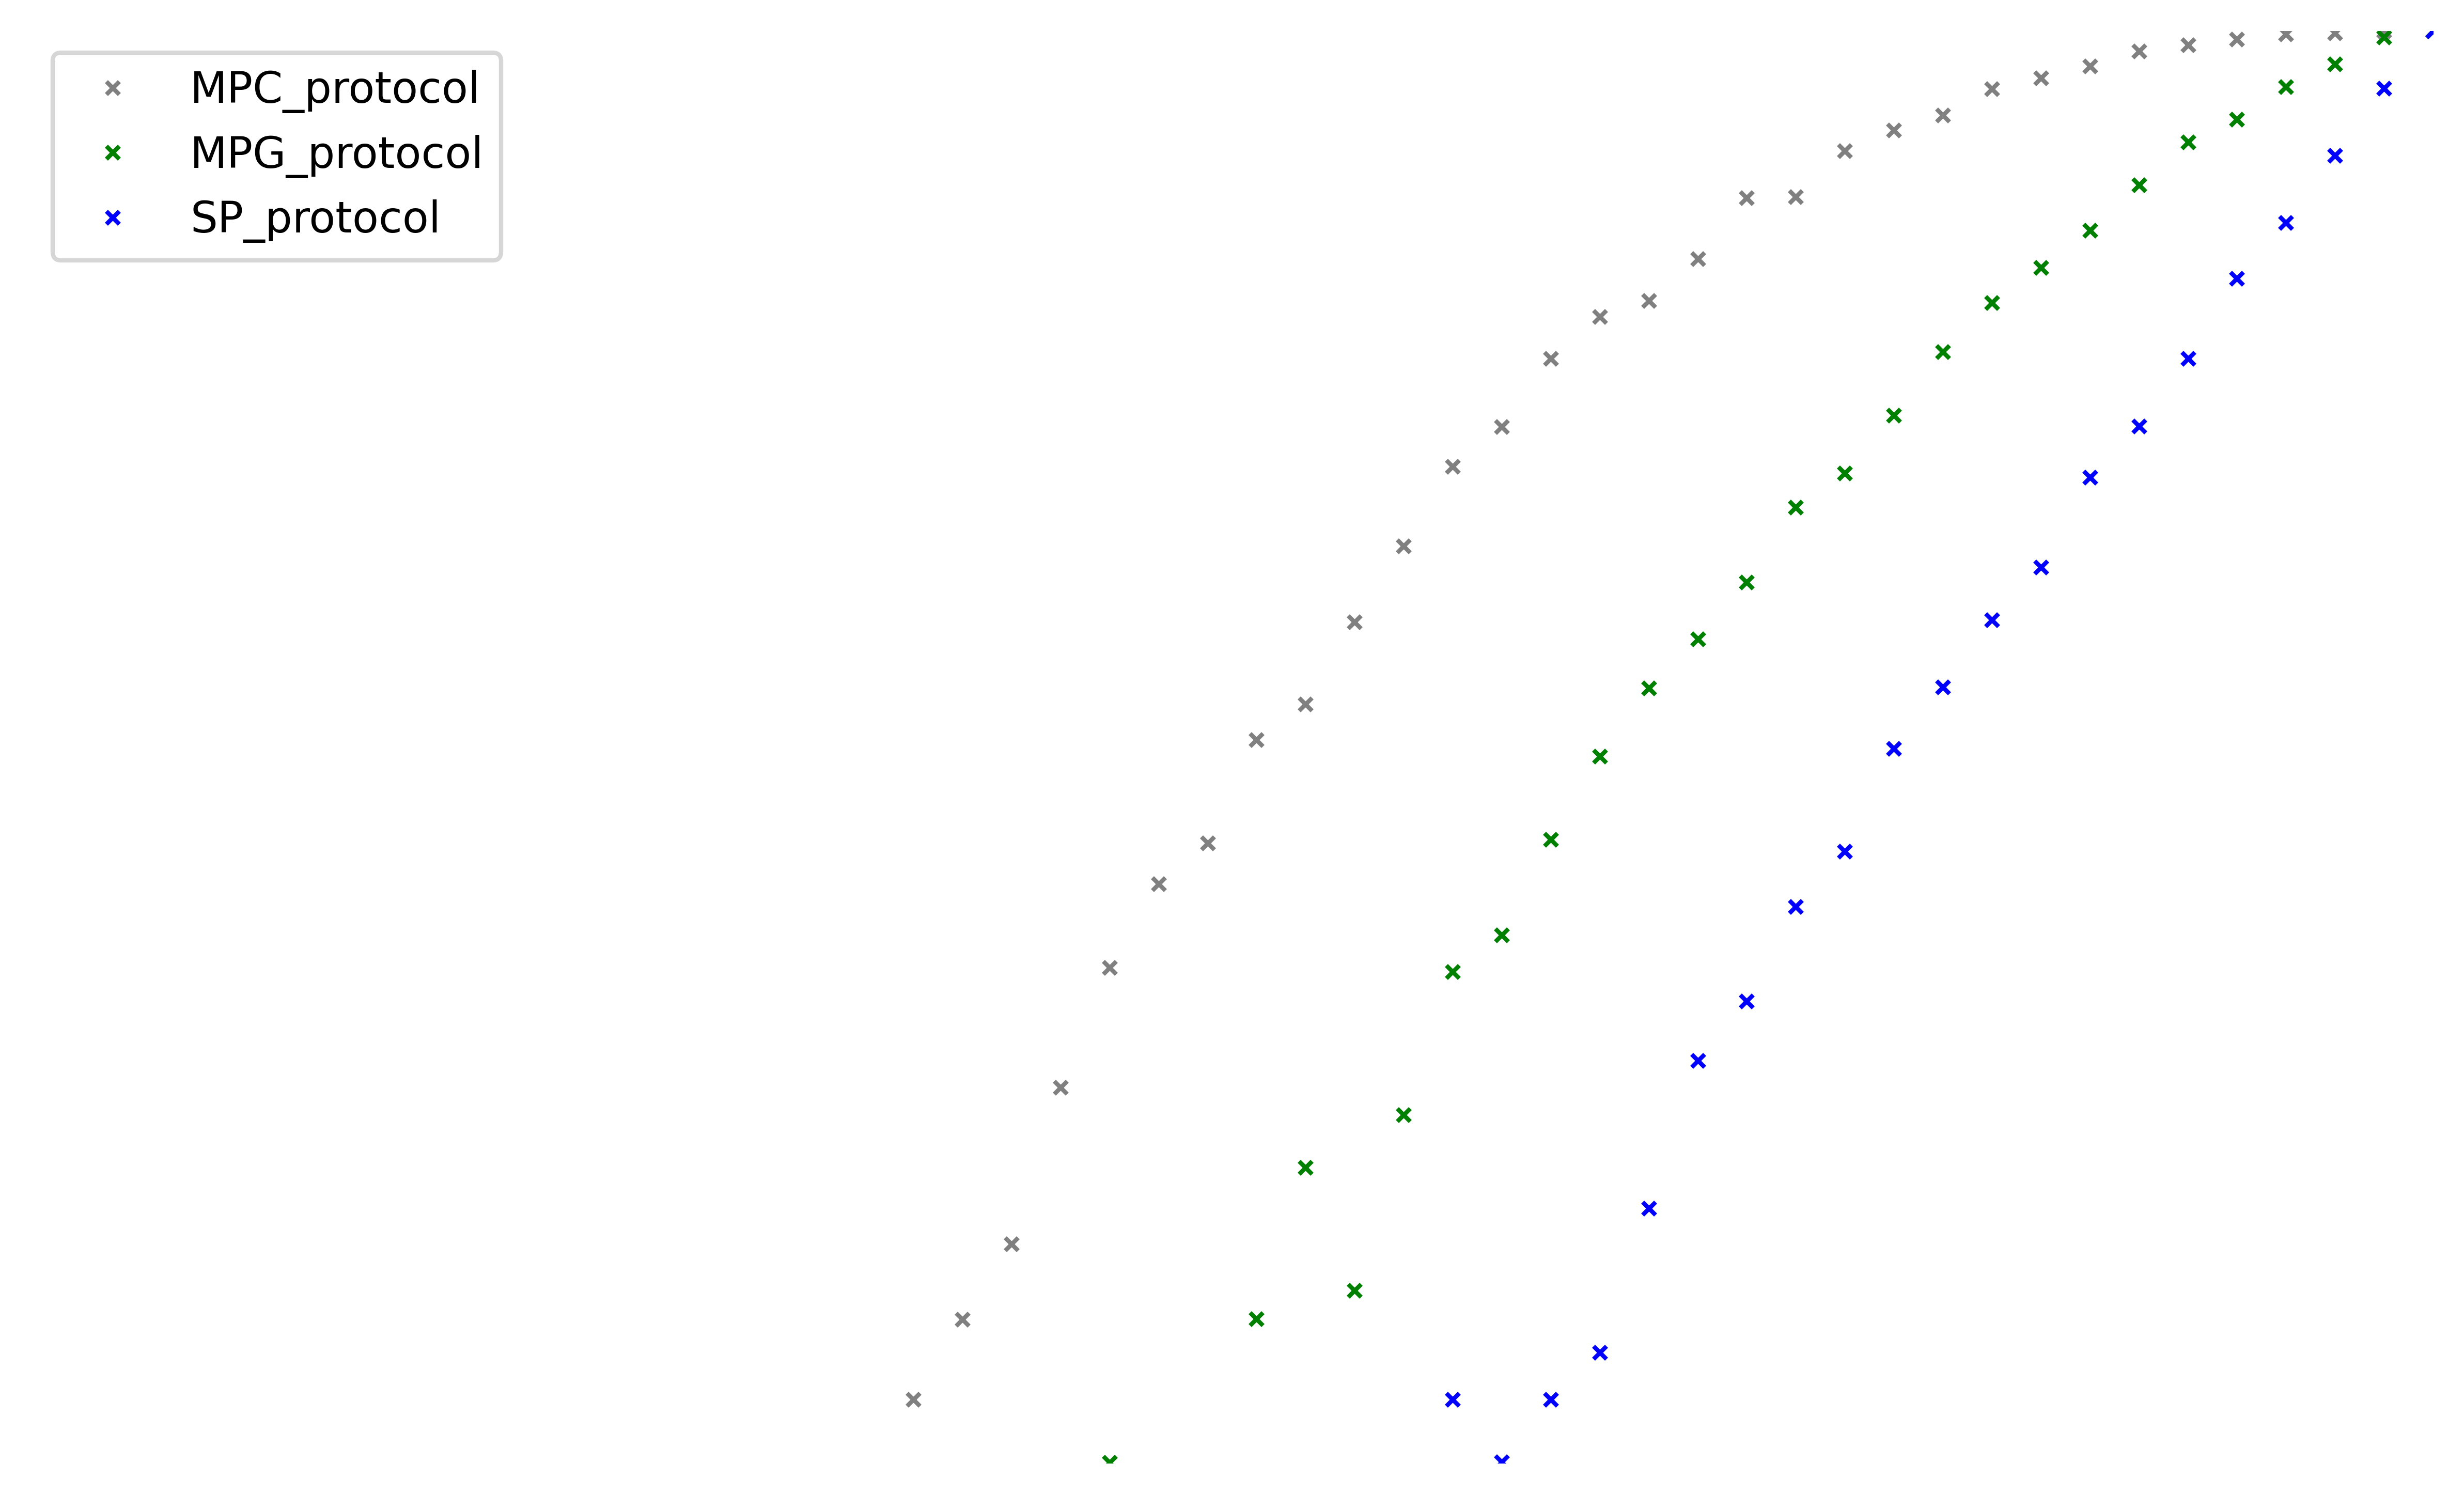

In [ ]:
funcs= [MPC_protocol,MPG_protocol,SP_protocol]
p_range = np.linspace(1, 0.2, 50)

timesteps = 100
reps = 200
alpha = 1.4
beta = 0.105
max_rounds = 10
shuffle_nodes = True
root_path = Path.cwd().parent.joinpath("graphs_json")

# 遍历 graphs_json 文件夹中的每个子文件夹
for subfolder in root_path.iterdir():
    if subfolder.is_dir():  # 判断是否是子文件夹
        #print(f"Processing subfolder: {subfolder}")
        # 遍历当前子文件夹中的所有文件
        for file in subfolder.iterdir():
            if file.is_file():  # 判断是否是文件
                #print(f"  Processing file: {file}")
                class_folder = Path(subfolder).name
                file_path = file.with_suffix(".png")
                file_name = Path(file_path).name
                er_output_path = Path.cwd().parent.joinpath("result",class_folder,file_name)
                communities_output_path = Path.cwd().parent.joinpath("communities",class_folder,file_name)


                ER = np.zeros((len(funcs),len(p_range)))
                G,users,pos = load_data(file)
                nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")
                G = network(G)
                communities,users = multi_iterative_score_partition_with_drawing(G, users[0],alpha,beta,max_rounds,
                                                                           shuffle_nodes,pos,communities_output_path)
            
                # 使用joblib并行化
                results = Parallel(n_jobs=-1, verbose=10)(
                    delayed(process_single_p)(G, users, p, funcs, timesteps, reps)
                    for p in p_range
                )
                # 将结果填充到ER矩阵
                for i, p_ers in enumerate(results):
                    ER[:, i] = p_ers

                # for i,p in enumerate(tqdm.tqdm(p_range)):# tqdm_notebook
                #     set_p_edge(G,p_op = p)
                #     for j,function in enumerate(funcs):
                #         er,multipartite_gen_time, links_used = function(G,users,timesteps=timesteps,reps=reps)
                #         ER[j,i]+=er
                print(ER)
                plot_er_vs_p(p_range, ER, funcs, cols, er_output_path)

